##### Import package

In [1]:
import os
import re
import sys
from pathlib import Path

import gffutils
import numpy as np
import pandas as pd
import pysam
from pandarallel import pandarallel
from tqdm import tqdm

### Import my modules in libs directory
try: 
    __file__
    sys.path.append(os.path.join(os.path.dirname(__file__)))
except NameError:
    Path().resolve()
    sys.path.append(os.path.join(Path().resolve(), '../../'))

from libs import utils, preprocess, variantfilter, posparser, splaiparser
from libs import predeffect, scoring
from libs import anno_spliceai, anno_clinvar
from libs.deco import print_filtering_count

### Logging setup
from logging import getLogger, config
import yaml
parent_directory = os.path.dirname(os.path.dirname('__file__'))
config_path: str = os.path.join(parent_directory, '../../config/logging.yaml')
with open(config_path, 'r') as f:
    config.dictConfig(yaml.safe_load(f))
logger = getLogger(__name__)


########   Initialize and setup pandas methods   ########
pandarallel.initialize(nb_workers=os.cpu_count()-1, progress_bar=False, 
                       verbose=2, use_memory_fs=False) 
os.environ['JOBLIB_TEMP_FOLDER'] = '/tmp' 
tqdm.pandas()

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
########   Import genocode DBs (exon DB and intron DB)   ########
try:
    db_anno_gencode = '../../Resources/06_gffutilsdb/gencode.v43lift37.annotation.gtf.db'
    db_anno_intron = '../../Resources/06_gffutilsdb/gencode.v43lift37.annotation.intron.gtf.db'
    db = gffutils.FeatureDB(db_anno_gencode)
    db_intron = gffutils.FeatureDB(db_anno_intron)
except ValueError:
    db_anno_gencode = '/resources/DBs/gencode.v43lift37.annotation.gtf.db'
    db_anno_intron = '/resources/DBs/gencode.v43lift37.annotation.intron.gtf.db'
    db = gffutils.FeatureDB(db_anno_gencode)
    db_intron = gffutils.FeatureDB(db_anno_intron)

########   Import TSVs, VCFs and GFFs   ########
### Downloaded database files
#1. Clinvar variants (BED format)
clinvar_file = '../../Resources/03_ClinVar/variant_summary.snv.grch37.germline.criteria.sort.bed.gz'
tbx_clinvar = pysam.TabixFile(clinvar_file)
#2. GENCODE file (GFF3 format)
gencode_gff = '../../Resources/05_GENCODE_v43lift37/gencode.v43lift37.annotation.sort.gff3.gz'
tbx_anno = pysam.TabixFile(gencode_gff)
#3. Canonical transcripts table
# canonlist = '../../CanonicalTranscripts_COMP/CanonicalTranscripts.exoncount.tsv'
canonlist = '../../Resources/01_CanonicalTranscripts/CanonicalTranscripts.exoncount.tsv'
#4. CCRs (BED format)
autoccr = '../../Resources/04_CCRs/ccrs.autosomes.v2.20180420.sort.bed.gz'
xccr = '../../Resources/04_CCRs/ccrs.xchrom.v2.20180420.sort.bed.gz'


## Thresholds configuration
thresholds_SpliceAI_parser: dict = {
    'TH_min_sALDL': 0.02, 'TH_max_sALDL': 0.2, 
    'TH_min_sAGDG': 0.01, 'TH_max_sAGDG': 0.05,
    'TH_min_GExon': 25, 'TH_max_GExon': 500,
    'TH_sAG': 0.2, 'TH_sDG': 0.2
    }

############ Functions for cleansing and adjusting HGMD data ############
def adjust_enst_for_hgmd(df: pd.DataFrame) -> pd.DataFrame:
    result = df.replace(
        {'gene': {'PRKN': 'PARK2', 'MICOS13': 'C19orf70'},
         'ENST': {'ENST00000263201': 'ENST00000437685'},
         'ENST_Full': {'ENST00000263201.7_4': 'ENST00000437685.6_1',
                       'ENST00000361547.7_7': 'ENST00000361547.7_8',
                       'ENST00000609375.1_7': 'ENST00000347364.7_5',
                       'ENST00000649912.1_4': 'ENST00000347364.7_5'}})
    return result

@print_filtering_count
def remove_unkown_refalt(df: pd.DataFrame) -> pd.DataFrame:
    result = df.dropna(subset='REF', axis=0)
    return result

## loading original file and setting output base path
# mydata = './original.snpeff.state.disease.filtered.splai.tsv'
mydata = './original.snpeff.state.disease.identifiedgene.filtered.splai.tsv'
results_splai = './results_spliceai_mydata.vcf'

### Loading files as pandas DataFrame ###
df = pd.read_table(mydata, sep='\t', dtype=str)
output_base: str = utils.configure_output(mydata)
vcf_columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO']
splai = pd.read_table(results_splai, sep='\t', header=None, names=vcf_columns)
canon = pd.read_table(canonlist, sep='\t', header=0)


In [3]:
print(len(df))
df = variantfilter.extract_denovo(df)
print(len(df))

16353
Start extract_denovo
Filtering : 16353 --> 9944

9944


In [4]:
################################################################################
#### Annotation step  ####

#1.   Classify 'Canonical' splice site or 'Non-canonical' splice site
logger.info('Classify "Canonical" splice site or "Non-canonical" splice site...')
df = posparser.classifying_canonical(df, cdot='c.HGVS')

#2.   Calculate exonic positions
logger.info('Calculating exonic positions...')
#2-1. Generate 'exonic upstream distance and exonic downstream distance
df['exon_loc'] = df.progress_apply(posparser.calc_exon_loc, tabixfile=tbx_anno, 
                          enstcolname='ENST', axis=1)
df = pd.concat([df, df['exon_loc'].str.split(':', expand=True)], axis=1)
df.rename(columns={0: 'ex_up_dist', 1: 'ex_down_dist'}, inplace=True)


#2-2. Select minimum distance from upstream distance and downstream distance
df['exon_pos'] = df.parallel_apply(posparser.select_exon_pos, axis=1)


#2-3. Decision exonic splice sites (1 nt in acceptor site or 3 nts on Donor site)
df['exon_splice_site'] = df.parallel_apply(posparser.extract_splicing_region, axis=1)

#3.   Additional Splicing information
logger.info('Annotating splicing information...')
#3-1. Annotate splicing type ('Exonic Acceptor' etc.)
df['SpliceType'] = df.parallel_apply(posparser.select_donor_acceptor, axis=1)

#3-2. Annotate rank of exon or intron
df['Num_ExInt'] = df.progress_apply(posparser.calc_ex_int_num, 
                                    db=db, db_intron=db_intron, axis=1)


#5.   Annotate ClinVar varaints interpretations
logger.info('Annotating ClinVar varaints interpretations...')
df['clinvar_same_pos'] = df.progress_apply(anno_clinvar.anno_same_pos_vars, 
                                           tabixfile=tbx_clinvar, axis=1)
df['clinvar_same_motif'] = df.progress_apply(anno_clinvar.anno_same_motif_vars, 
                                             tabixfile=tbx_clinvar, axis=1)

#6.   Parising SpliceAI results (For PVS1 decision tree)
logger.info('Parsing SpliceAI results...')
## Thresholds configuration
TH_min_sALDL, TH_max_sALDL = 0.02, 0.2
TH_min_sAGDG, TH_max_sAGDG = 0.01, 0.05
TH_min_GExon, TH_max_GExon = 25, 500
TH_sAG, TH_sDG = 0.2, 0.2


#6-1. Annotate Exon/Intron position information
df['ExInt_INFO'] = df.progress_apply(splaiparser.calc_exint_info, 
                                     db=db, 
                                     db_intron=db_intron, 
                                     axis=1)

#6-2. Relative exon location
df['prc_exon_loc'] = df.parallel_apply(posparser.calc_prc_exon_loc, axis=1)


#6-3. Predict splicing effects
df['Pseudoexon'] = df.progress_apply(
    splaiparser.pseudoexon_activation,
    thresholds=thresholds_SpliceAI_parser, 
    db_intron=db_intron,
    axis=1)

df['Part_IntRet'] = df.parallel_apply(
    splaiparser.partial_intron_retention,
    thresholds=thresholds_SpliceAI_parser, 
    axis=1)

df['Part_ExDel'] = df.parallel_apply(
    splaiparser.partial_exon_deletion,
    thresholds=thresholds_SpliceAI_parser, 
    axis=1)

df['Exon_skipping'] = df.parallel_apply(
    splaiparser.exon_skipping, 
    thresholds=thresholds_SpliceAI_parser, 
    axis=1)
                                        
df['Int_Retention'] = df.parallel_apply(
    splaiparser.intron_retention, 
    thresholds=thresholds_SpliceAI_parser, 
    axis=1)

df['multiexs'] = df.parallel_apply(
    splaiparser.multi_exon_skipping, 
    thresholds=thresholds_SpliceAI_parser, 
    axis=1)


#7.   Annotate aberrant splicing size (bp)
logger.info('Annotating aberrant splicing size (bp)...')
#7-1. Annotate size of 
df['Size_Part_ExDel'] = df.parallel_apply(
    splaiparser.anno_partial_exon_del_size, 
    thresholds=thresholds_SpliceAI_parser, 
    axis=1)

#7-3. Annotate size of partial intron retention
df['Size_Part_IntRet'] = df.parallel_apply(
    splaiparser.anno_partial_intron_retention_size, 
    thresholds=thresholds_SpliceAI_parser,
    axis=1)

#7-2. Annotate size of pseudoexon
df['Size_pseudoexon'] = df.parallel_apply(
    splaiparser.anno_gained_exon_size, 
    thresholds=thresholds_SpliceAI_parser, 
    axis=1)

#7-4. Annotate size of intron retention
df['Size_IntRet'] = df.parallel_apply(
    splaiparser.anno_intron_retention_size, 
    thresholds=thresholds_SpliceAI_parser,
    axis=1)

#7-5. Annotate size of exon skipping
df['Size_skipped_exon'] = df.parallel_apply(
    splaiparser.anno_skipped_exon_size, 
    thresholds=thresholds_SpliceAI_parser,
    axis=1)

#8.   Evaluate splicing effects
logger.info('Predicting CDS change...')
#8-1. Predict CDS change
df['CDS_Length'] = df.progress_apply(predeffect.calc_cds_len, db=db, axis=1)
df['is_10%_truncation'] = df.progress_apply(predeffect.calc_cds_len_shorten, axis=1)

#8-2. Determine if the gene is included in eLoFs genes
df['is_eLoF'] = df.parallel_apply(predeffect.elofs_judge, axis=1)

#8-3. Determine causing NMD or not
df['is_NMD_at_Canon'] = df.parallel_apply(predeffect.nmd_judge, axis=1)

#8-4. Frame check
df['is_Frameshift_Part_ExDel'] = df['Size_Part_ExDel'].parallel_apply(
    predeffect.frame_check)
df['is_Frameshift_Part_IntRet'] = df['Size_Part_IntRet'].parallel_apply(
    predeffect.frame_check)
df['is_Frameshift_pseudoexon'] = df['Size_pseudoexon'].parallel_apply(
    predeffect.frame_check)
df['is_Frameshift_IntRet'] = df['Size_IntRet'].parallel_apply(
    predeffect.frame_check)
df['is_Frameshift_skipped_exon'] = df['Size_skipped_exon'].parallel_apply(
    predeffect.frame_check)
df['is_Frameshift'] = df[['is_Frameshift_Part_ExDel', 
                          'is_Frameshift_Part_IntRet', 
                          'is_Frameshift_pseudoexon', 
                          'is_Frameshift_IntRet', 
                          'is_Frameshift_skipped_exon'
                          ]].any(axis=1)


#9.   CCRs
logger.info('Annotating CCRs info...')

#9-1. Annotate truncated regions 
df['skipped_region'] = df.parallel_apply(
    splaiparser.anno_skipped_regions, axis=1)

df['deleted_region'] = df.parallel_apply(
    splaiparser.anno_deleted_regions, 
    thresholds=thresholds_SpliceAI_parser, axis=1)

#9-2. Intersect with CCRs
logger.info('Annotate CCR score')
df = predeffect.anno_ccr_score(df)

df.to_pickle('mydata.tmp.pkl')
df = pd.read_pickle('mydata.tmp.pkl')

2024/04/22 02:17:08 [INFO   ] (__main__) - Classify "Canonical" splice site or "Non-canonical" splice site...
-2: 27
-1: 25
+1: 53
+2: 21
Total variants      : 9944
Canonical variants  : 126
non-Canon variants  : 9818

2024/04/22 02:17:09 [INFO   ] (__main__) - Calculating exonic positions...


100%|██████████| 9944/9944 [00:05<00:00, 1841.69it/s]


2024/04/22 02:17:14 [INFO   ] (__main__) - Annotating splicing information...


100%|██████████| 9944/9944 [00:06<00:00, 1456.46it/s]

2024/04/22 02:17:21 [INFO   ] (__main__) - Annotating ClinVar varaints interpretations...



100%|██████████| 9944/9944 [00:00<00:00, 20020.38it/s]

2024/04/22 02:17:22 [INFO   ] (__main__) - Parsing SpliceAI results...



100%|██████████| 9944/9944 [00:01<00:00, 6012.66it/s]


2024/04/22 02:17:40 [INFO   ] (__main__) - Annotating aberrant splicing size (bp)...
2024/04/22 02:17:41 [INFO   ] (__main__) - Predicting CDS change...


100%|██████████| 9944/9944 [00:00<00:00, 109167.94it/s]

2024/04/22 02:17:50 [INFO   ] (__main__) - Annotating CCRs info...
2024/04/22 02:17:50 [INFO   ] (__main__) - Annotate CCR score


In [5]:
### Don't touch the original data ###
### Save the result as pickle file before scoring ###
df.to_pickle('./pickles/mydata_prescore.pkl')

In [6]:
#10.   Scoring
df = pd.read_pickle('./pickles/mydata_prescore.pkl')
from libs import scoring
logger.info('Annotating Screening scores...')
df = df.astype({'maxsplai': 'float', 'vqslod': 'float', 
                'denovogear': float, 'triodenovo': float, 'dnmfilter': float})
print(len(df))

# Recalibrate the thresholds for De novo detection
df = df[df['vqslod'] > -7.18]
df =df[(df['denovogear'] > 0.02) 
       | (df['triodenovo'] > 5.72)
       | (df['dnmfilter'] > 0.196)]

print(len(df))
df['insilico_screening'] = df.parallel_apply(scoring.insilico_screening, axis=1)
df['clinvar_screening'] = df.parallel_apply(scoring.clinvar_screening, axis=1)
df = scoring.calc_priority_score(df)

2024/04/22 02:17:59 [INFO   ] (__main__) - Annotating Screening scores...
9944
9944


In [7]:
df.to_pickle(f'./pickles/mydata.scored.pickle')


In [9]:
df = pd.read_pickle(f'./pickles/mydata.scored.pickle')
df.replace({'\u2161': 'II', '\u2163': 'IV', '\u2162': 'III'}, inplace=True, regex=True)
df.fillna('.', inplace=True)
df.rename(columns={'gene_x': 'gene', 'ID_x': 'ID'}, inplace=True)
path_to_hgmd = '../../Resources/07_HGMD_GeneBasedInfo/HGMD_GeneBasedInfo_2023.4.tsv.gz'

def anno_hgmd(df: pd.DataFrame) -> pd.DataFrame:
    hgmd = pd.read_table(path_to_hgmd, header=0, dtype=str)
    hgmd = hgmd[['gene', 'altsymbol', 'refseq', 
                 'expected_inheritance', 'hgncID', 'omimid', 'DM']]
    hgmd = hgmd.astype({'DM': 'float64'})
    df = pd.merge(
        df, hgmd, left_on='Gene.refGene', right_on='gene', how='left'
        )

    return df

df = anno_hgmd(df)
df = df.drop(columns=['gene_y', 'ID_y'])
print(df.duplicated(subset=['sample', 'ID']).sum())
df.drop_duplicates(subset=['sample', 'ID'], inplace=True)
print(len(df))

423
9521


/var/folders/60/yz_x62ts3ln6z030yykm0h2r0000gn/T/ipykernel_10405/1655380308.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '.' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna('.', inplace=True)


In [22]:
df.to_csv(f'./ExcelOutput/mydata.denovo.final.tsv', sep='\t', index=False, encoding='shift-jis')

<Axes: ylabel='count'>

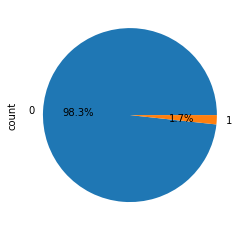

In [20]:
# Plot ratio of each category (solved or not)


In [10]:
df_solved = df[df['State'] == 'Identified']
df_unsolved = df[df['State'] == 'Undetermined']

In [21]:
df_unsolved.to_excel(f'./ExcelOutput/mydata.denovo.unsolved.xlsx', index=False)

In [12]:
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [16]:
# Distribution of Priority scores (Solved cases vs. Unsolved cases) using Plotly

fig = go.Figure()
fig.add_trace(go.Histogram(x=df_unsolved['PriorityScore'], name='Unsolved'))
fig.add_trace(go.Histogram(x=df_solved['PriorityScore'], name='Solved'))
fig.update_layout(barmode='overlay', title='Distribution of Priority scores (Solved cases vs. Unsolved cases)')
fig.update_traces(opacity=0.5)
fig.show()

In [39]:
df_undetermined_patho = df_undetermined[df_undetermined['FinalScore'] >= 4]
df_undetermined_patho.to_excel(f'./undetermined_patho.xlsx', index=False)

In [14]:
df_undetermined_vus = df_undetermined[df_undetermined['FinalScore'] == 3]
df_undetermined_vus.to_excel(f'./undetermined_vus.xlsx', index=False)

In [26]:
df_solved_patho = df_solved[df_solved['PrioritySscore'] >= 4]

In [28]:
df_solved_patho.to_csv(f'./ExcelOutput/mydata.solved.patho.tsv', sep='\t', index=False, encoding='shift-jis')

In [30]:
df_solved_patho.to_excel(f'./ExcelOutput/mydata.solved.patho.xlsx', index=False)


In [19]:
df['FinalScore'].value_counts()

FinalScore
1    8835
0    4711
2     933
3     859
4      92
5      80
6      65
7      21
8       8
9       1
Name: count, dtype: int64

In [20]:
# Show table of final scores distribution
tb = df_undetermined['FinalScore'].value_counts()
tb = tb.sort_index()


In [32]:
# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [33]:
# Plot the distribution of the final score using bar plot with log scale
# x-axis: Final score (all scores are shown)
# y-axis: Number of variants

fig = px.bar(tb, x=tb.index, y=tb.values,
                labels={'x': 'Final score', 'y': 'Number of variants'},
                title='Priority score distribution',
                log_y=True)
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1
    )
)
# X-axis title
fig.update_xaxes(title_text='Priority score')
# Y-axis title
fig.update_yaxes(title_text='Number of variants (log scale)')

fig.show()

# Saving the html file
fig.write_html('final_score_distribution.html')


In [40]:
# Plot the ratio between identified and undetermined variants
print(len(df_solved), len(df_undetermined))

# Pie chart
# color as soft color palette
colors = sns.color_palette('pastel')[0:2]
fig = go.Figure(data=[go.Pie(labels=['Identified', 'Undetermined'], 
                             values=[len(df_solved), len(df_undetermined)])])
fig.update_traces(marker=dict(colors=colors))
fig.update_layout(title='Ratio between identified and undetermined variants')

# Add number of variants
fig.add_annotation(
    x=0.2, y=0.5, showarrow=False,
    text=f'Identified: {len(df_solved)}<br>Undetermined: {len(df_undetermined)}',
    font=dict(size=20)
)

# legend location
fig.update_layout(legend=dict(
    yanchor='top',
    y=0.1,
    xanchor='left',
    x=0.3
))

fig.show()

# Saving the html file
fig.write_html('identified_undetermined_ratio.html')

3892 11713


In [44]:
import codecs
with codecs.open("mydata.solved.patho.matched.txt", "r", "Shift-JIS", "ignore") as file:
    df = pd.read_table(file, delimiter="\t")

In [49]:
# Plot bar plot for priority score distribution
# x-axis: Priority score
# y-axis: Number of variants (not log scale)
# color: (is_gene_match == True) or (is_gene_match == False)
fig = px.bar(df, x='PrioritySscore', color='is_gene_match',
             labels={'PrioritySscore': 'Priority score', 'count': 'Number of variants'},
             title='Priority score distribution',
             log_y=True)

# X-axis title
fig.update_xaxes(title_text='Priority score')
# Y-axis title
fig.update_yaxes(title_text='Number of variants (log scale)')
# Legend title
fig.update_layout(legend_title_text='Re-visited solved cases for WES analysis data')

fig.show()


In [40]:
# A number of >=4 final score variants in undetermined variants
print(len(df_undetermined_patho))

188


In [46]:
# plot the distribution of the final score in identified variants
tb2 = df_identified['FinalScore'].value_counts()
tb2 = tb2.sort_index()

# x-axis: Final score (all scores are shown) log sacale
# y-axis: Number of variants
# color: Red
fig = px.bar(tb2, x=tb2.index, y=tb2.values,
                labels={'x': 'Final score', 'y': 'Number of variants'},
                title='Priority score distribution in identified variants',
                log_y=True)
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        tick0=0,
        dtick=1
    )
)

# X-axis title
fig.update_xaxes(title_text='Priority score')

# Y-axis title
fig.update_yaxes(title_text='Number of variants (log scale)')
fig.show()

# save html file
fig.write_html('final_score_distribution_identified.html')

In [26]:
df_patho = df[df['FinalScore'] >= 4]

In [27]:
df_patho.to_csv(f'./mydata.final.patho.tsv', sep='\t', index=False, encoding='shift-jis')

### Note

In [18]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [19]:
labels = ['Very high priority', 'High priority', 'Moderate priority', 'Low priority', 'Very low priority']
value = [len(df.loc[df['Final_Prediction'] == 'Very high priority']), 
         len(df.loc[df['Final_Prediction'] == 'High priority']), 
         len(df.loc[df['Final_Prediction'] == 'Moderate priority']), 
         len(df.loc[df['Final_Prediction'] == 'Low priority']), 
         len(df.loc[df['Final_Prediction'] == 'Very low priority'])]
fig = px.bar(x=labels, y=value, height=600, width=800, title='HGMD variant interpretation', template='seaborn')
fig.update_layout(xaxis=dict(title='Classification'),
                 yaxis=dict(title='Nmuber of variants'))

fig.show()

##### 次のセルは，SpliceAIの結果をマージした時のもの．

In [ ]:
df2 = pd.read_table(
    '/work/Github/MyProjects/SplicingScreening/data/ResultsPredictionTools/results_spliceai_raw_maxdistance.nonheader.final.vcf',
    sep='\t', dtype=str, header=None) 
df2.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO']
df2['variant_id'] = df2.apply(preprocess.generate_variant_id_col, axis=1)
df2 = df2[df2['INFO'] != '.']

df3 = pd.read_table('/work/Github/MyProjects/SplicingScreening/data/ResultsPredictionTools/reanalysis.splai.NMfixed.parsed.vcf',
                    sep='\t', dtype=str, header=None)
df3.columns = ['CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO']
df3['variant_id'] = df3.apply(preprocess.generate_variant_id_col, axis=1)    

df4 = pd.concat([df2, df3], axis=0)
df4[df4.duplicated(subset='variant_id', keep='last')].sort_values(by='variant_id')
df4 = df4[['CHROM', 'POS', 'variant_id', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO']]

df4.to_csv('results_spliceai_mydata.vcf', sep='\t', index=False)

##### Creating DBs


In [ ]:
################################################################################
##                                Creating DBs                                ##
################################################################################

import gffutils
import gffutils.pybedtools_integration

## Function
def generate_intoron_gtf(db: gffutils.FeatureDB, output: str) -> None:
    introns = db.create_introns(exon_featuretype='exon', 
                                new_featuretype='intron', 
                                merge_attributes=True, 
                                numeric_sort=True)
    pybed = gffutils.pybedtools_integration.to_bedtool(introns)
    pybed.saveas(output)
    
    return None


## Set path to GTF files for creating DBs
gencode_gtf = '/resources/GENCODE/gencode.v43lift37.annotation.gtf.gz'
intron_gtf = '/resources/GENCODE/gencode.v43lift37.annotation.intron.gtf.gz'

## Set path to output DBs
db_anno_gencode = '/work/resources/gencode.v43lift37.annotation.gtf.db'
db_anno_intron = '/work/resources/gencode.v43lift37.annotation.intron.gtf.db'

#1. Create DB from GENCODE GTF
db = gffutils.create_db(gencode_gtf, db_anno_gencode,
                        disable_infer_genes=True, 
                        disable_infer_transcripts=True,
                        keep_order=True)

db = gffutils.FeatureDB(db_anno_gencode)

#2. Create intron information file as GTF
generate_intoron_gtf(db, intron_gtf)

#3. Create intron DB from above GTF
id_spec_dict = {'gene': 'gene_id', 'transcript': 'transcript_id',
                'exon_number': 'intron_number'}
db_intron = gffutils.create_db(intron_gtf, db_anno_intron, 
                               disable_infer_genes=True, 
                               disable_infer_transcripts=True, 
                               keep_order=True,
                               merge_strategy="merge")